In [1]:
%pylab inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import datetime as dt

Populating the interactive namespace from numpy and matplotlib


In [2]:
import yatsm
from yatsm.io import read_pixel_timeseries
from yatsm.utils import csvfile_to_dataframe, get_image_IDs
from yatsm.config_parser import convert_config, parse_config_file
from yatsm.config_parser import convert_config, parse_config_file
import yatsm._cyprep as cyprep

Read in config file and dates:

In [129]:
## SPECIFY CONFIG FILE
config_file = '/projectnb/landsat/projects/Massachusetts/p012r031/p012r031_config.yaml'

# Read in and parse config file
cfg = parse_config_file(config_file)

In [130]:
# Get files list
df = csvfile_to_dataframe(cfg['dataset']['input_file'], \
                          date_format=cfg['dataset']['date_format'])

In [131]:
# Get dates
df['image_ID'] = get_image_IDs(df['filename']) 
df['x'] = df['date'] 
dates = df['date'].values

Specify pixel to run:

In [132]:
# SPECIFY PIXEL TO RUN
py = 1858 # row
px = 4628 # column

Configure model and read in time series:

In [7]:
# Configure model
#model = cfg['YATSM']['algorithm_cls']
#algo_cfg = cfg[cfg['YATSM']['algorithm']]
#yatsm = model(estimator=cfg['YATSM']['estimator'], \
#                  **algo_cfg.get('init', {}))
#yatsm.px = px
#yatsm.py = py

In [8]:
# Setup algorithm and create design matrix (if needed)
#X = yatsm.setup(df, **cfg)
#design_info = getattr(X, 'design_info', None)

In [133]:
# Read in time series as numpy array
Y = read_pixel_timeseries(df['filename'], px, py)

Mask time series based on physical constraints and Fmask:

In [135]:
# Mask based on physical constraints and Fmask 
valid = cyprep.get_valid_mask( \
            Y, \
            cfg['dataset']['min_values'], \
            cfg['dataset']['max_values']).astype(bool)

# Apply mask band
idx_mask = cfg['dataset']['mask_band'] - 1
valid *= np.in1d(Y.take(idx_mask, axis=0), \
                         cfg['dataset']['mask_values'], \
                         invert=True).astype(np.bool)

Y = np.delete(Y, idx_mask, axis=0)[:, valid]
#X = X[valid, :]
dates = dates[valid]

Plot example time series:

In [136]:
# convert time from ordinal to dates
dt_dates = np.array([dt.datetime.fromordinal(d) for d in dates])


In [137]:
# Set band to plot
band = 8

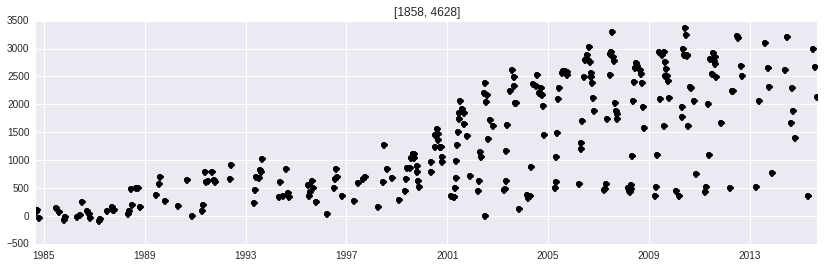

In [138]:
# Plot time series - visual check
plt.figure(figsize=(14,4),facecolor='w', edgecolor='k')
plt.plot(dt_dates, Y[band, :],'ko')
plt.title([py, px])
plt.show()

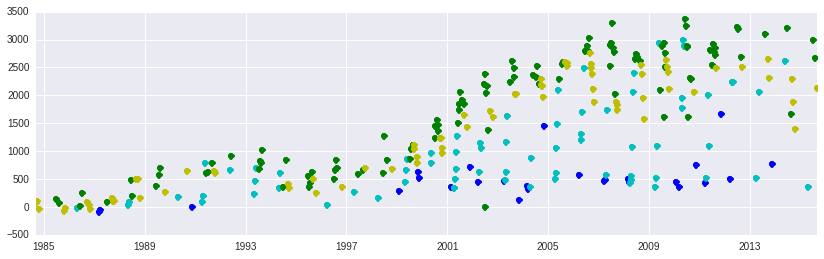

In [171]:
plt.figure(figsize=(14,4),facecolor='w', edgecolor='k')

for date in dt_dates:
    if date.month == 11 or date.month == 12 or date.month == 1 or date.month == 2 or date.month == 3:
        plt.plot(date, Y[band, np.where(dt_dates==date)],'bo')
    elif date.month == 4 or date.month == 5:
        plt.plot(date, Y[band, np.where(dt_dates==date)],'co')
    elif date.month == 6 or date.month == 7 or date.month == 8:
        plt.plot(date, Y[band, np.where(dt_dates==date)],'go')
    else:
        plt.plot(date, Y[band, np.where(dt_dates==date)],'yo')
        
    
plt.show()

Correlation Analysis:

In [140]:
# Read np array into pandas dataframe - exclude Fmask result
Y_df = pd.DataFrame(Y[0:10])

In [141]:
# Transpose time series dataframe for correlation analysis
Y_t = Y_df.transpose()
Y_t.columns = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', \
                        'Thermal', 'Brightness', 'Greenness', 'Wetness'] 

In [142]:
# Calculate pearson correlation matrix
corr_df = Y_t.corr(method='pearson')
corr_df

,Blue,Green,Red,NIR,SWIR1,SWIR2,Thermal,Brightness,Greenness,Wetness
Blue,1.000000,0.967426,0.943473,-0.418059,0.420647,0.726308,-0.066588,0.585101,-0.689850,-0.407914
Green,0.967426,1.000000,0.965028,-0.373689,0.486312,0.785446,0.033395,0.660707,-0.667569,-0.455373
Red,0.943473,0.965028,1.000000,-0.556567,0.530179,0.875146,-0.076486,0.532130,-0.810306,-0.604057
NIR,-0.418059,-0.373689,-0.556567,1.000000,-0.049827,-0.546024,0.424371,0.386417,0.937380,0.527594
SWIR1,0.420647,0.486312,0.530179,-0.049827,1.000000,0.780625,0.139634,0.680745,-0.268028,-0.847429
SWIR2,0.726308,0.785446,0.875146,-0.546024,0.780625,1.000000,-0.007494,0.496804,-0.758680,-0.894798
Thermal,-0.066588,0.033395,-0.076486,0.424371,0.139634,-0.007494,1.000000,0.361296,0.325979,0.069120
Brightness,0.585101,0.660707,0.532130,0.386417,0.680745,0.496804,0.361296,1.000000,0.045824,-0.281943
Greenness,-0.689850,-0.667569,-0.810306,0.937380,-0.268028,-0.758680,0.325979,0.045824,1.000000,0.635801
Wetness,-0.407914,-0.455373,-0.604057,0.527594,-0.847429,-0.894798,0.069120,-0.281943,0.635801,1.000000


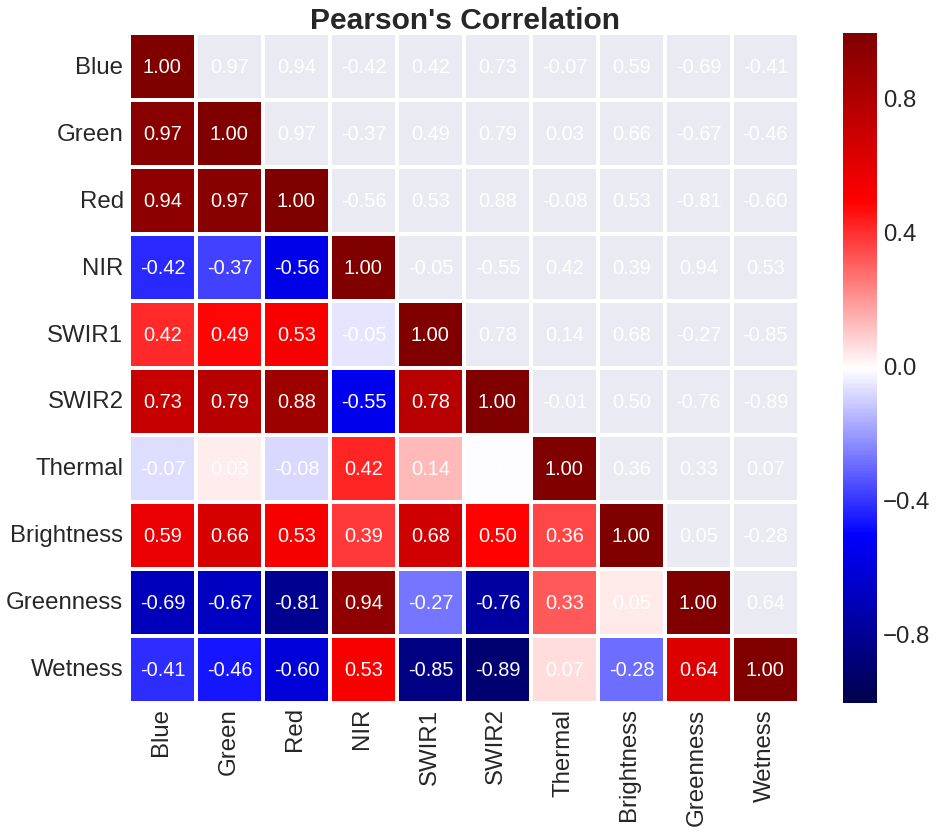

In [143]:
# Create a mask to display only the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal).
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask, 1)] = True

# Create the heatmap using seaborn library. 
# List if colormaps (parameter 'cmap') is available here: http://matplotlib.org/examples/color/colormaps_reference.html

plt.figure(figsize=(16,12),facecolor='w', edgecolor='k')
seaborn.heatmap(corr_df, cmap='seismic', vmax=1.0, vmin=-1.0, linewidths=2.5, mask = mask, square=True)
seaborn.heatmap(corr_df, cmap='gist_rainbow', cbar=False, annot=True, fmt='0.2f', annot_kws={"size": 20}, alpha=0.0, square=True)

# Show the plot we reorient the labels for each column and row to make them easier to read.
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=24)

plt.yticks(rotation=0, size=24) 
plt.xticks(rotation=90, size=24)
plt.title("Pearson's Correlation", size=30, weight='bold')
plt.show()

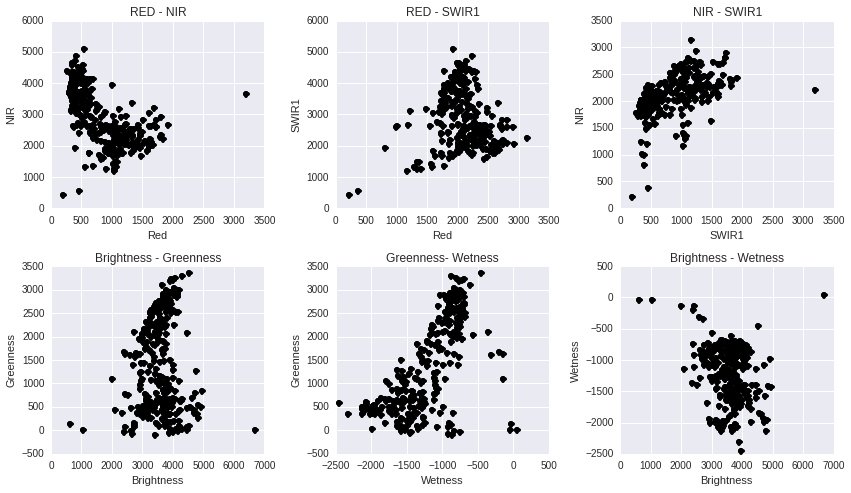

In [150]:
fig1 = plt.figure(figsize=(12,7))

plt.subplot2grid((2,3),(0,0))
plt.plot(Y[2, :], Y[3, :], 'ko')
plt.ylabel('NIR')
plt.xlabel('Red')
plt.title('RED - NIR')

plt.subplot2grid((2,3),(0,2))
plt.plot(Y[2, :], Y[4, :], 'ko')
plt.ylabel('NIR')
plt.xlabel('SWIR1')
plt.title('NIR - SWIR1')

plt.subplot2grid((2,3),(0,1))
plt.plot(Y[4, :], Y[3, :], 'ko')
plt.ylabel('SWIR1')
plt.xlabel('Red')
plt.title('RED - SWIR1')

plt.subplot2grid((2,3),(1,0))
plt.plot(Y[7, :], Y[8, :], 'ko')
plt.ylabel('Greenness')
plt.xlabel('Brightness')
plt.title('Brightness - Greenness')

plt.subplot2grid((2,3),(1,2))
plt.plot(Y[7, :], Y[9, :], 'ko')
plt.ylabel('Wetness')
plt.xlabel('Brightness')
plt.title('Brightness - Wetness')

plt.subplot2grid((2,3),(1,1))
plt.plot(Y[9, :], Y[8, :], 'ko')
plt.ylabel('Greenness')
plt.xlabel('Wetness')
plt.title('Greenness- Wetness')

fig1.tight_layout()
plt.show()